## Summary note of the phonon olympics entry for Germanium

- **Author**: Terumasa TADANO (NIMS)
- **Date**: Jan. 27, 2022.
- **Codes**: VASP 6.2.1 + ALAMODE 1.3.0 (some new features of dev branch are also tested)
- **Compilers**: Intel Compiler version 20.0.2.254 + Intel MKL
- **Compile flags**: `-O2` for ALAMODE, `-O2 -xHOST` for VASP
- **MPI library**: HPE MPI 2.21
- **Computer Resource**: NIMS simulator (Intel Xeon Platinum 8268 24core 2.9 GHz x 2 / node)

In [1]:
from pymatgen.io.vasp.outputs import Vasprun, Procar, Outcar

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib as mpl

import openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.set_option('display.max_rows', 100)

params = {'backend': 'ps',
          'text.latex.preamble': ['\\usepackage{gensymb}'],
          'axes.labelsize': 22, # fontsize for x and y labels (was 10)
          'axes.titlesize': 10,
          'font.size': 11, # was 10
          'legend.fontsize': 6, # was 10
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': False,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial'
}

mpl.rcParams.update(params)

In [2]:
font = Font(size=14, name='Calibri')

def write_dataframe_to_excel(ws, pd, irow = 1, icol = 1, adjust_width=True):
    
    rows = dataframe_to_rows(pd, index=False, header=True)
    
    for row_no, row in enumerate(rows, irow):
        for col_no, value in enumerate(row, icol):
            ws.cell(row=row_no, column=col_no, value=value).font = font
            
    if adjust_width:
        for col in ws.columns:
            max_length = 0
            column = col[0].column

            for cell in col:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
                
            adjusted_width = (max_length + 2)
            ws.column_dimensions[get_column_letter(column)].width = adjusted_width

In [3]:
vasp_ismear2_kmesh = pd.read_table('VASP/1.Structure/convergence_check/ISMEAR=2/convergence_kmesh.dat', 
                                   header=None, skiprows=2, delim_whitespace=True, 
                                   names=('# k points along each axis', 
                                          'energy (eV)', 'lattice constant (Ang.)'))

vasp_ismear2_encut = pd.read_table('VASP/1.Structure/convergence_check/ISMEAR=2/convergence_encut.dat', 
                                   header=None, skiprows=2, delim_whitespace=True, 
                                   names=('ENCUT (eV)', 'energy (eV)', 'lattice constant (Ang.)'))


ionic_steps = []
cores_info = []
elapsed_times = []
encut_range = np.arange(200, 1001, 50)
for encut in encut_range:
    vasprun = Vasprun('VASP/1.Structure/convergence_check/ISMEAR=2/vasprun_ENCUT%d.k=12.xml' % encut)
    ionic_steps.append(len(vasprun.as_dict()['output']['ionic_steps']))
    outcar = Outcar('VASP/1.Structure/convergence_check/ISMEAR=2/OUTCAR.ENCUT%d.k=12' % encut)
    cores_info.append(int(outcar.run_stats['cores']))
    elapsed_times.append(outcar.run_stats['Elapsed time (sec)'])
    
vasp_ismear2_encut['ionic_steps'] = ionic_steps
vasp_ismear2_encut['cores'] = cores_info
vasp_ismear2_encut['Elapsed time (sec)'] = elapsed_times


ionic_steps = []
cores_info = []
elapsed_times = []
kmesh_range = np.arange(5, 21, 1)
for kmesh in kmesh_range:
    vasprun = Vasprun('VASP/1.Structure/convergence_check/ISMEAR=2/vasprun_ENCUT500.k=%d.xml' % kmesh)
    ionic_steps.append(len(vasprun.as_dict()['output']['ionic_steps']))
    outcar = Outcar('VASP/1.Structure/convergence_check/ISMEAR=2/OUTCAR.ENCUT500.k=%d' % kmesh)
    cores_info.append(int(outcar.run_stats['cores']))
    elapsed_times.append(outcar.run_stats['Elapsed time (sec)'])

vasp_ismear2_kmesh['ionic_steps'] = ionic_steps
vasp_ismear2_kmesh['cores'] = cores_info
vasp_ismear2_kmesh['Elapsed time (sec)'] = elapsed_times


## 1. Structure - summary

The calculations were performed using `VASP` code with the following input parameters:
```
 PREC = Accurate
 ENCUT = 300
 EDIFF = 1.0e-8
 EDIFFG = -1.0e-4
 ISMEAR = 2
 SIGMA = 0.2
 ALGO= Normal
 LREAL = .FALSE.
 ADDGRID = .TRUE.
 LWAVE = .FALSE.
 LCHARG = .FALSE.
 ICHARG= 2
 ISTART=0
 NELM=200

 NPAR = 8
 ISIF = 3
 IBRION = 2
 NSW = 100
 POTIM = 0.1

 GGA = PS
 ```

As shown in the tables and figures below, the lattice constant obtained from the variable-cell relaxation (`ISIF=3`) appears to reach convergence at 8x8x8 k points and `ENCUT=300`. So, I have chosen

- **ENCUT = 300**
- **8x8x8 k points for primitive**
- **a = 5.7019 Angstrom**

for the following electronic/phonon calculations.

<div class="alert alert-block alert-info">
<b>Note:</b> The k point may be denser for supercell calculations as described in the phonon dispersion part.

In [4]:
vasp_ismear2_encut

,ENCUT (eV),energy (eV),lattice constant (Ang.),ionic_steps,cores,Elapsed time (sec)
0,200,-9.789082,5.70080,4,96,13.557
1,250,-9.790439,5.70250,3,96,8.925
2,300,-9.791442,5.70199,4,96,8.242
3,350,-9.792332,5.70202,3,96,7.098
4,400,-9.792902,5.70231,3,96,8.194
5,450,-9.793038,5.70243,3,96,8.021
6,500,-9.793123,5.70239,3,96,7.977
7,550,-9.793240,5.70232,3,96,7.604
8,600,-9.793352,5.70232,1,96,5.874
9,650,-9.793414,5.70238,3,96,8.895


In [5]:
vasp_ismear2_kmesh

,# k points along each axis,energy (eV),lattice constant (Ang.),ionic_steps,cores,Elapsed time (sec)
0,5,-9.687007,5.71213,3,96,2.227
1,6,-9.791674,5.70153,4,96,3.766
2,7,-9.770145,5.70430,3,96,2.577
3,8,-9.792838,5.70229,5,96,5.862
4,9,-9.786484,5.70219,8,96,4.549
5,10,-9.793064,5.70242,3,96,5.923
6,11,-9.790658,5.70225,12,96,7.895
7,12,-9.793123,5.70239,3,96,7.977
8,13,-9.792114,5.70253,3,96,4.833
9,14,-9.793118,5.70228,7,96,17.006


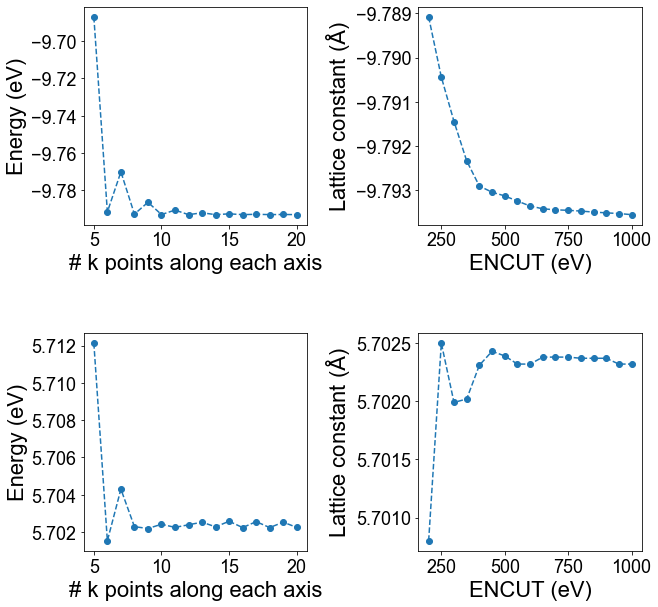

In [6]:
# Plot figure below
fig = plt.figure(figsize=(10,10))

nrows = 2; ncols = 2
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.5)

ax = plt.subplot(gs[0,0])
vasp_ismear2_kmesh.plot(x=0,y=1,kind='line', ylabel='Energy (eV)', marker='o', linestyle='--', ax=ax, legend=False)
ax = plt.subplot(gs[1,0])
vasp_ismear2_kmesh.plot(x=0,y=2,kind='line', legend=False,
                        ylabel='Energy (eV)', marker='o', linestyle='--', ax=ax)
ax = plt.subplot(gs[0,1])
vasp_ismear2_encut.plot(x=0,y=1,kind='line', legend=False,
                        ylabel='Lattice constant ($\mathrm{\AA}$)', marker='o', linestyle='--', ax=ax)
ax = plt.subplot(gs[1,1])
vasp_ismear2_encut.plot(x=0,y=2,kind='line', legend=False,
                        ylabel='Lattice constant ($\mathrm{\AA}$)', marker='o', linestyle='--', ax=ax)
plt.savefig('convergence_structure.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Electronic band opt.

from pymatgen.electronic_structure.core import Spin, Orbital

dosrun= Vasprun("./VASP/2.Electrons/ISMEAR=2/vasprun_scf.xml", parse_dos=True)
dos = dosrun.complete_dos
bs = Vasprun(
    "./VASP/2.Electrons/ISMEAR=2/vasprun_band.xml").get_band_structure(
    "./VASP/2.Electrons/ISMEAR=2/KPOINTS.band", 
    efermi=dosrun.efermi, 
    line_mode=True)

efermi1 = dos.efermi
kval1 = np.array(bs.distance)
data1 = bs.bands[Spin.up]

dosrun= Vasprun("./VASP/2.Electrons/ISMEAR=2/vasprun_scf_denser.xml", parse_dos=True)
dos = dosrun.complete_dos
bs = Vasprun(
    "./VASP/2.Electrons/ISMEAR=2/vasprun_band_denser.xml").get_band_structure(
    "./VASP/2.Electrons/ISMEAR=2/KPOINTS.band", 
    efermi=dosrun.efermi, 
    line_mode=True)

efermi2 = dos.efermi
kval2 = np.array(bs.distance)
data2 = bs.bands[Spin.up]

In [8]:
# re-organize data in pandas dataframe format

nb = 10

bs1 = []
bs2 = []

ranges = [[0, 101], [101, 303], [303, 404]]
xadjust = [0, 2.2038884534563805, 3.7622729]
pathes = ['G-X', 'G-K-X', 'G-L']

for i, ra in enumerate(ranges):
    df = pd.DataFrame()

    x = kval1[ra[0]:ra[1]] - xadjust[i]
    y = data1[0:nb,ra[0]:ra[1]] - efermi1
    
    x /= x[-1]
    df['k_distance (normalized)'] = x
    for ib in range(nb):
        df['E%d' % (ib + 1)] = y[ib,:]
        
    df.attrs['efermi'] = efermi1
    df.attrs['line'] = pathes[i]
    df.attrs['SCF'] = '(SCF 8x8x8 MP k points)'
    bs1.append(df)
    
for i, ra in enumerate(ranges):
    df = pd.DataFrame()
    
    x = kval2[ra[0]:ra[1]] - xadjust[i]
    y = data2[0:nb,ra[0]:ra[1]] - efermi2
    
    x /= x[-1]
    df['k_distance (normalized)'] = x
    for ib in range(nb):
        df['E%d' % (ib + 1)] = y[ib,:]
        
    df.attrs['efermi'] = efermi2
    df.attrs['line'] = pathes[i]
    df.attrs['SCF'] = '(SCF 12x12x12 MP k points)'
    bs2.append(df)

## 2. Electronic - summary
The electronic band dispersion obtained from the 8x8x8 k points agrees well with the result obtained from the denser 12x12x12 k points. So, we conclude that 8x8x8 kpoints was accurate enough.

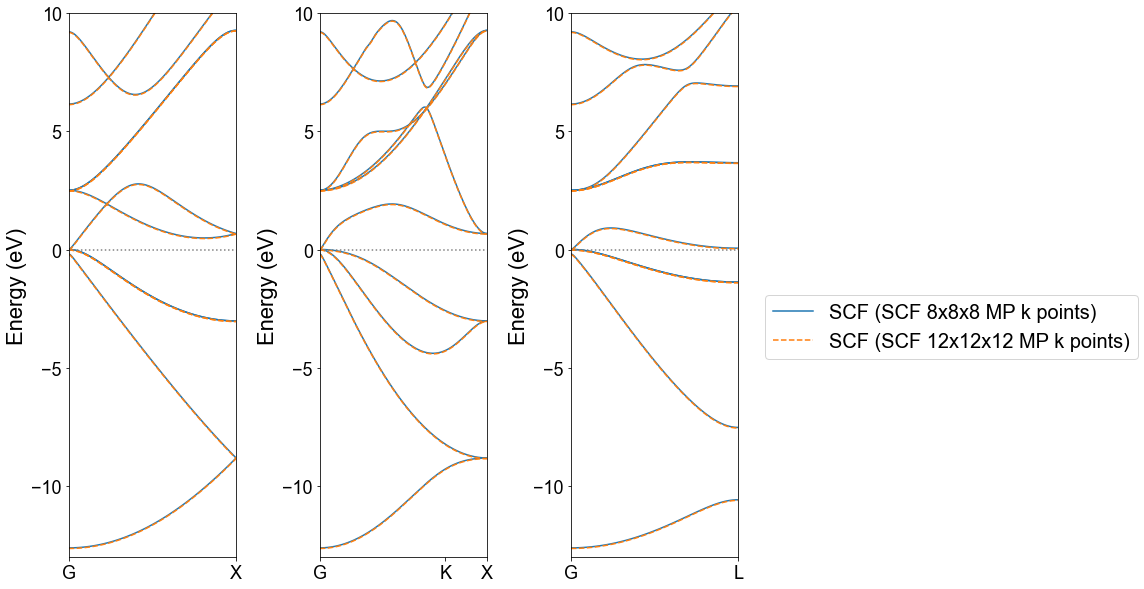

In [9]:
fig = plt.figure(figsize=(12,10))
nrows = 1
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.5)

ranges = [[0, 101], [101, 303], [303, 404]]
labels = [['G', 'X'], ['G', 'K', 'X'], ['G', 'L']]
tickvals = [[0, 1.1019442], [2.2038885, 3.3726768, 3.7622729], [3.7622729, 4.7165846]]


for iax, ra in enumerate(ranges):
    
    ax = plt.subplot(gs[iax])
    
    ax.plot(bs1[iax]['k_distance (normalized)'], 
            bs1[iax]['E1'], linestyle='-', 
            marker='None', color='C0', label='SCF %s' % bs1[iax].attrs['SCF'])
    
    for ib in range(2, 11):
        ax.plot(bs1[iax]['k_distance (normalized)'], 
                bs1[iax]['E%d' % ib], linestyle='-', 
                marker='None', color='C0')
        
    ax.plot(bs2[iax]['k_distance (normalized)'], 
            bs2[iax]['E1'], linestyle='--', 
            marker='None', color='C1', label='SCF %s' % bs2[iax].attrs['SCF'])
    
    for ib in range(2, 11):
        ax.plot(bs2[iax]['k_distance (normalized)'], 
                bs2[iax]['E%d' % ib], linestyle='--', 
                marker='None', color='C1')
    
    xmin = tickvals[iax][0]
    xmax = tickvals[iax][-1]
    tickvals[iax][:]= (np.array(tickvals[iax][:])-xmin)/(xmax-xmin)
    ax.set_xlim(tickvals[iax][0], tickvals[iax][-1])
    ax.set_xticklabels(labels[iax])
    ax.set_xticks(tickvals[iax])
    ax.set_ylim(-13, 10)
    ax.set_ylabel('Energy (eV)')
    ax.axhline(y=0.0, linestyle=':', color='gray')
    if iax == 2:
        ax.legend(fontsize=20, bbox_to_anchor=(1.1, 0.5))

plt.savefig('ElectronicBandStructure.pdf', dpi=300, bbox_inches='tight')        
plt.show()

In [28]:
# 3. Harmonic calculation

vasprun = Vasprun('VASP/3.Harmonic/222/convergence_check/vasprun_disp1_ENCUT200.xml')

incar_ph222 = vasprun.as_dict()['input']['incar']
alm_222 = {}
anphon_222 = {}
alm_222['supercell size'] = '222'
alm_222['magnitude of displacement (Ang.)'] = 0.01
anphon_222['Mass'] = 72.63
encut_list = np.arange(200, 801, 50)

headers = ['ENCUT (eV)', 'k mesh style', 'k mesh', 'k mesh shift', 
           'f_G1', 
           'f_X1', 'f_X2', 'f_X3', 
           'f_L1', 'f_L2', 'f_L3', 'f_L4']

frequencies = np.loadtxt('VASP/3.Harmonic/222/convergence_check/convergence_encut.dat')

kpoint_info = []
for encut in encut_list:
    vasprun_dict = Vasprun('VASP/3.Harmonic/222/convergence_check/vasprun_disp1_ENCUT%d.xml' % encut).as_dict()['input']['kpoints']
    kpoint_info.append([vasprun_dict['generation_style'],
                        vasprun_dict['kpoints'][0],
                        vasprun_dict['shift']])


summary_ph222_convcheck = pd.read_table('VASP/3.Harmonic/222/convergence_check/convergence_encut.dat', 
                                   header=None, skiprows=1, delim_whitespace=True, 
                                   names=('ENCUT (eV)', 'f_G1', 'f_X1', 'f_X2', 'f_X3', 'f_L1', 'f_L2', 'f_L3', 'f_L4'))
list_kp = list(zip(*kpoint_info))
summary_ph222_convcheck['k mesh style'] = list_kp[0]
summary_ph222_convcheck['k mesh'] = list_kp[1]
summary_ph222_convcheck['k mesh shift'] = list_kp[2]

## 3.1 Harmonic - convergence at G, X, and L points

The phonon frequencies at Gamma (0,0,0), X(0.5, 0.5, 0), and L(0.5, 0.5, 0.5) points are calculated using the following conditions:

- 2x2x2 supercell (16 atoms)
- displacement magnitude : 0.01 Angstrom
- make full use of symmetry (permutation, space group)
- consider ASR as constraint
- Fit displacement-force dataset by ordinary least squares

The results of convergence check with respect to `ENCUT` are shown in the table and figure. As `ENCUT` increases, the frequencies tend to increase gradually and eventually reach convergence at `ENCUT ~ 600`. Still, our initial choice of `ENCUT = 300` already gives very reasonable results and meets the target accuracy of < 0.1 THz.

In [11]:
summary_ph222_convcheck

,ENCUT (eV),f_G1,f_X1,f_X2,f_X3,f_L1,f_L2,f_L3,f_L4,k mesh style,k mesh,k mesh shift
0,200,8.4898,2.1055,6.9020,7.8668,1.7014,6.3573,6.9656,8.2978,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]"
1,250,8.4916,2.1038,6.9009,7.8671,1.7006,6.3565,6.9641,8.2988,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]"
2,300,8.4926,2.1046,6.9020,7.8683,1.7010,6.3575,6.9656,8.2999,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]"
3,350,8.4935,2.1031,6.9020,7.8690,1.6998,6.3571,6.9658,8.3007,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]"
4,400,8.4943,2.1048,6.9028,7.8697,1.7010,6.3581,6.9667,8.3014,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]"
5,450,8.4942,2.1047,6.9025,7.8695,1.7010,6.3578,6.9662,8.3012,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]"
6,500,8.4944,2.1044,6.9026,7.8697,1.7007,6.3577,6.9663,8.3014,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]"
7,550,8.4948,2.1047,6.9029,7.8701,1.7009,6.3581,6.9668,8.3018,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]"
8,600,8.4949,2.1049,6.9031,7.8703,1.7010,6.3582,6.9670,8.3020,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]"
9,650,8.4950,2.1052,6.9032,7.8703,1.7013,6.3584,6.9670,8.3020,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]"


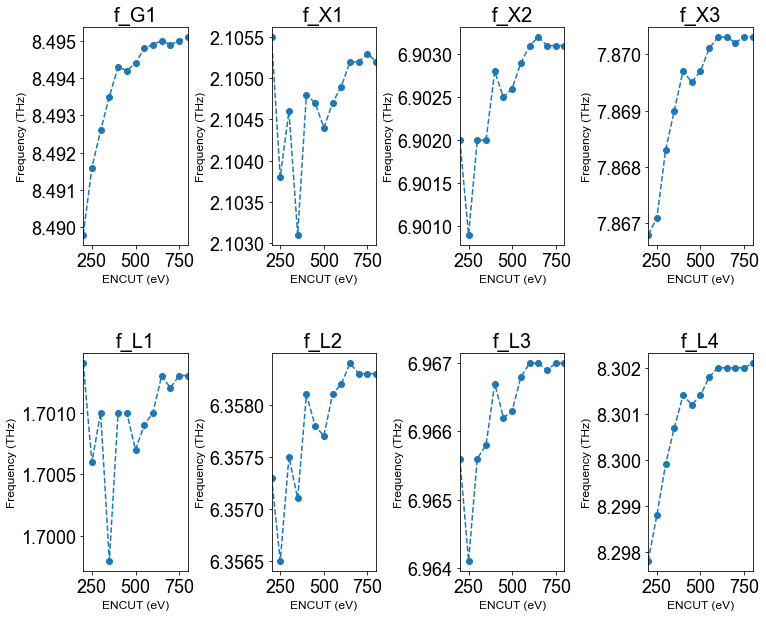

In [12]:
fig = plt.figure(figsize=(12,10))
nrows = 2
ncols = 4

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.8)

icount = 0
for irow in range(nrows):
    for icol in range(ncols):
        ax = plt.subplot(gs[irow, icol])
        
        icount +=1
        ax.plot(frequencies[:,0], frequencies[:,icount], linestyle='--', marker='o')
        ax.set_title(headers[icount+3], fontsize=20)
        ax.set_xlim(200, 800)
        ax.set_xlabel('ENCUT (eV)', fontsize=12)
        ax.set_ylabel('Frequency (THz)', fontsize=12)

plt.show()

In [29]:
supercells = ['222', '222conv', '222conv_fine', '444', '333conv', 
              '444conv', '444conv_fine']
supercell_labels = ['222', '222 conv.', '222 conv. denser k', '444', '333 conv.', 
                    '444 conv.', '444 conv. denser k']

data = [['Supercell (SC) size', 
        '# atoms in SC', 
        'ENCUT',
        'k mesh style', 'k mesh', 'k mesh shift',
        '# of cores', 'Total CPU time (sec.)', 'Wall time (sec.)',
        'magnitude of\ndisplacement (Ang.)']]

dispmag = 0.01

for i, sc in enumerate(supercells):
    vasprun = Vasprun('VASP/3.Harmonic/%s/vasprun_disp1_ENCUT300.xml' % sc)
    outcar = Outcar('VASP/3.Harmonic/%s/OUTCAR.disp1.300' % sc)
    
    vasprun_dict = vasprun.as_dict()
    data.append([supercells[i],
                 vasprun_dict['nsites'],
                 vasprun_dict['input']['incar']['ENCUT'],
                 vasprun_dict['input']['kpoints']['generation_style'],
                 str(vasprun_dict['input']['kpoints']['kpoints'][0]),
                 str(vasprun_dict['input']['kpoints']['shift']),
                 outcar.as_dict()['run_stats']['cores'],
                 outcar.as_dict()['run_stats']['Total CPU time used (sec)'],
                 outcar.as_dict()['run_stats']['Elapsed time (sec)'],
                 dispmag])
    
summary_phband_settings = pd.DataFrame(data[1:], columns=data[0])
phband_data = []

header=['q']
for i in range(1, 7):
    header.append('f%d' %i)
pathes = ['G-X', 'G-K-X', 'G-L']

ranges = [[0, 101], [101, 303], [303, 404]]
labels = [['G', 'X'], ['G', 'K', 'X'], ['G', 'L']]
tickvals = [[0.000000, 0.583124],  [0.583124, 1.201620, 1.407785], [1.407785, 1.912785]]

kayser_to_THz = 0.0299792458

for i, sc in enumerate(supercells):
    
    phband_data_now = []
    scname = sc.split('_')[0]
    phband = np.loadtxt('VASP/3.Harmonic/%s/supercell%s_0.01_300.bands' % (sc, scname))
    nbands = len(phband[0,:]) - 1

    for j, path in enumerate(pathes):
        
        pd_tmp = pd.DataFrame()
        pd_tmp.attrs['SC'] = supercell_labels[i]
        nrows = ranges[j][1]-ranges[j][0]
        data = np.zeros((nrows, 7))
        data[:,0] = (phband[ranges[j][0]:ranges[j][1],0]-phband[ranges[j][0],0])
        data[:,0] /= data[-1,0]
        data[:,1:] = phband[ranges[j][0]:ranges[j][1],1:7]
        data[:,1:] *= kayser_to_THz
        
        pd_tmp['q (normalized)'] = data[:,0]
        for k in range(1, 7):
            pd_tmp['f%d' % k] = data[:,k]
        pd_tmp.attrs['line'] = path
        phband_data_now.append(pd_tmp)
    
    phband_data.append(phband_data_now)


## 3.2 Harmonic - convergence of dispersion

To examine the convergence of phonon dispersion curves, we have performed phonon calculations using various supercells and k points as summarized below:

In [30]:
summary_phband_settings

,Supercell (SC) size,# atoms in SC,ENCUT,k mesh style,k mesh,k mesh shift,# of cores,Total CPU time (sec.),Wall time (sec.),magnitude of\ndisplacement (Ang.)
0,222,16,300.0,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]",96,13.830,14.293,0.01
1,222conv,64,300.0,Gamma,"[3, 3, 3]","[0.0, 0.0, 0.0]",96,33.521,35.776,0.01
2,222conv_fine,64,300.0,Monkhorst,"[4, 4, 4]","[0.5, 0.5, 0.5]",96,48.116,51.821,0.01
3,444,128,300.0,Monkhorst,"[2, 2, 2]","[0.5, 0.5, 0.5]",96,160.485,166.963,0.01
4,333conv,216,300.0,Monkhorst,"[2, 2, 2]","[0.5, 0.5, 0.5]",96,183.162,186.060,0.01
5,444conv,512,300.0,Gamma,"[1, 1, 1]","[0.0, 0.0, 0.0]",96,608.538,612.415,0.01
6,444conv_fine,512,300.0,Monkhorst,"[2, 2, 2]","[0.5, 0.5, 0.5]",192,1143.610,1150.086,0.01


The results are plotted in the **figure below.**

For the supercell size, 222 conventional (`222 conv. denser k`) appears to be adequate, but using a larger conventional supercell (`333 conv.` or `444 conv. denser k`) slightly improves the accuracy. Also, when the k mesh shift is 0 (or when the k mesh density is not enough?), the TO frequency at Gamma was underestimated. So, we will use the "denser k" option when necessary.

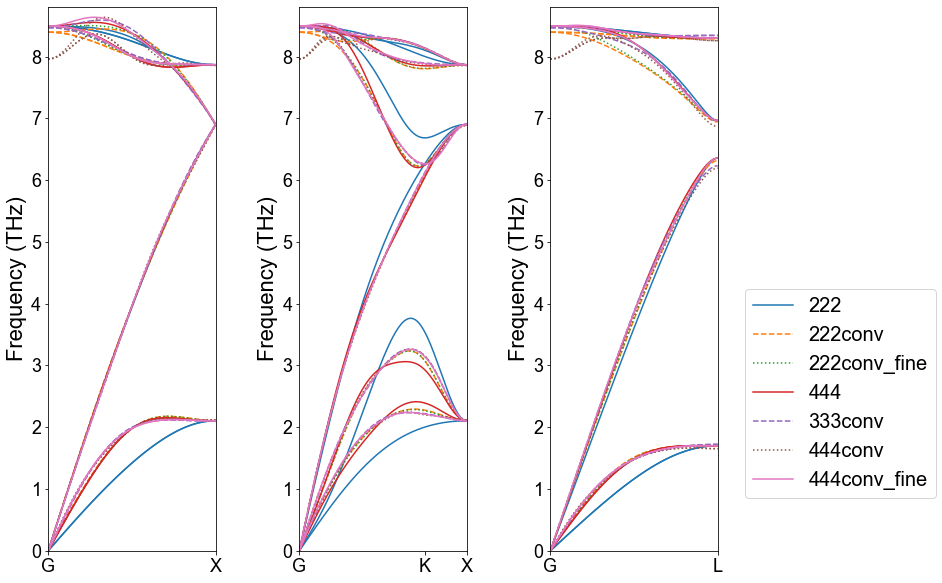

In [15]:
fig = plt.figure(figsize=(12,10))
nrows = 1
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.5)

cl = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
ls = ['-', '--', ':']

for iax, ra in enumerate(ranges):
    ax = plt.subplot(gs[iax])

    for i, sc in enumerate(supercells):
        scname = sc.split('_')[0]
        phband = np.loadtxt('VASP/3.Harmonic/%s/supercell%s_0.01_300.bands' % (sc, scname))
        phband2 = phband_data[i][iax]
   
        ax.plot(phband2['q (normalized)'], phband2['f1'],
                linestyle=ls[i%3],
                marker='None',
                color=cl[i%7], 
                label=sc)

        for ib in range(1,6):
            ax.plot(phband2['q (normalized)'], phband2['f%d' % (ib + 1)],
                    linestyle=ls[i%3],
                    marker='None',
                    color=cl[i%7]) 

        ax.set_ylim(0, 8.8)
        xmin = tickvals[iax][0]
        xmax = tickvals[iax][-1]
        tickvals[iax][:]= (np.array(tickvals[iax][:])-xmin)/(xmax-xmin)
        ax.set_xlim(tickvals[iax][0], tickvals[iax][-1])
        ax.set_xticklabels(labels[iax])
        ax.set_xticks(tickvals[iax])
        ax.set_ylabel('Frequency (THz)')
    if iax == 2:
        ax.legend(fontsize=20, bbox_to_anchor=(1.1, 0.5))

plt.savefig('PhononBandStructure.pdf', dpi=300, bbox_inches='tight')        
plt.show()

In [16]:
import glob


def get_kappa_from_file(fname, temperature):
    retval = None
    with open(fname, 'r') as f:
        for line in f.readlines():
            if str(temperature) in line:
                if float(line.strip().split()[0]) == temperature:
                    retval = float(line.strip().split()[1])
                    break
    return retval

def get_num_displacements(fname):
    retval = None
    
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "Number of disp. patterns for   ANHARM3" in line:
                retval = int(line.strip().split(':')[1])
                break
    return retval


def get_num_irred_ifc3(fname):
    retval = None
    
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "Number of free  ANHARM3 FCs" in line:
                retval = int(line.strip().split(':')[1])
                break
    return retval


def get_nodehour_vasp(dirname):
    outcars = glob.glob("%s/OUTCAR.*" % dirname)
    
    retval = []
    
    nodehours = 0.0
    ncores_per_node = 48
    
    for outcar in outcars:
        obj = Outcar(outcar).as_dict()
        retval.append([obj['run_stats']['cores'],
                       obj['run_stats']['Total CPU time used (sec)'],
                       obj['run_stats']['Elapsed time (sec)']])
        
        nodehours += (int(obj['run_stats']['cores']) // ncores_per_node) \
                     * obj['run_stats']['Elapsed time (sec)']
        
    return nodehours / float(3600), retval


#sheet = wb.create_sheet(title='4.Anharmonic (VASP, conv. check)')

temperature = 300

kappa_222conv_mic1 = []
kappa_222conv_mic2 = []
ndisp_222conv = []
nifc3_222conv = []

kappa_333conv_mic1 = []
kappa_333conv_mic2 = []
ndisp_333conv = []
nifc3_333conv = []

kappa_ha333_anh222_mic1 = []
kappa_ha333_anh222_mic2 = []

nnlist = np.arange(1, 19, 1)

nodehour_vasp_222conv = []
nodehour_vasp_333conv = []

kappa_all = pd.DataFrame()

rcinfo1 = np.loadtxt('VASP/4.Anharmonic/222conv/nninfo.txt', usecols=[1,])
nodehour = 0.0

kappa_all_list = []


sc_size_ifc2 = '222conv_fine'
sc_size_ifc3 = '222conv_fine'
qmesh = '30 30 30'

for i, nn in enumerate(nnlist[:9]):
    fname1 = 'VASP/4.Anharmonic/222conv/%dnn/cubic_correct_mass.kl' % nn
    fname2 = 'VASP/4.Anharmonic/222conv/%dnn/cubic_correct_mass_dev.kl' % nn
    fname3 = 'VASP/4.Anharmonic/222conv/%dnn/ALM0.log' % nn
    fname4 = 'VASP/4.Anharmonic/222conv/%dnn/ALM1.log' % nn
    fname5 = 'VASP/4.Anharmonic/222conv/%dnn/ALM2.log' % nn
    kappa_tmp1 = get_kappa_from_file(fname1, temperature)
    kappa_tmp2 = get_kappa_from_file(fname2, temperature)
    ndisp = get_num_displacements(fname3)
    nifc3_tmp1 = get_num_irred_ifc3(fname4)
    nifc3_tmp2 = get_num_irred_ifc3(fname5)
    nodehour_sub, _ = get_nodehour_vasp('VASP/4.Anharmonic/222conv/%dnn' % nn)
    nodehour += nodehour_sub

    kappa_222conv_mic1.append(kappa_tmp1)
    kappa_222conv_mic2.append(kappa_tmp2)
    ndisp_222conv.append(ndisp)
    nifc3_222conv.append([nifc3_tmp1, nifc3_tmp2])
    nodehour_vasp_222conv.append(nodehour)

    rcval = rcinfo1[i]
    mirror_image_conv = 0
    
    kappa_all_list.append([sc_size_ifc2, 
                           sc_size_ifc3, 
                           rcval,
                           nn,
                           ndisp,
                           mirror_image_conv,
                           nifc3_tmp1,
                           kappa_tmp1,
                           qmesh,
                           nodehour])
    
    mirror_image_conv = 1
    
    kappa_all_list.append([sc_size_ifc2, 
                           sc_size_ifc3, 
                           rcval,
                           nn,
                           ndisp,
                           mirror_image_conv,
                           nifc3_tmp2,
                           kappa_tmp2,
                           qmesh,
                           nodehour])
    

nifc3_222conv = np.array(nifc3_222conv)

sc_size_ifc2 = '333conv'
sc_size_ifc3 = '333conv'

nodehour = 0.0
rcinfo2 = np.loadtxt('VASP/4.Anharmonic/333conv/nninfo.txt', usecols=[1,])
for i, nn in enumerate(nnlist):
    fname1 = 'VASP/4.Anharmonic/333conv/%dnn/cubic.kl' % nn
    fname2 = 'VASP/4.Anharmonic/333conv/%dnn/cubic_dev.kl' % nn
    fname3 = 'VASP/4.Anharmonic/333conv/%dnn/ALM0.log' % nn
    fname4 = 'VASP/4.Anharmonic/333conv/%dnn/ALM1.log' % nn
    fname5 = 'VASP/4.Anharmonic/333conv/%dnn/ALM2.log' % nn
    
    kappa_tmp1 = get_kappa_from_file(fname1, temperature)
    kappa_tmp2 = get_kappa_from_file(fname2, temperature)
    ndisp = get_num_displacements(fname3)
    nifc3_tmp1 = get_num_irred_ifc3(fname4)
    nifc3_tmp2 = get_num_irred_ifc3(fname5)
    nodehour_sub, _ = get_nodehour_vasp('VASP/4.Anharmonic/333conv/%dnn' % nn)
    nodehour += nodehour_sub

    kappa_333conv_mic1.append(kappa_tmp1)
    kappa_333conv_mic2.append(kappa_tmp2)
    ndisp_333conv.append(ndisp)
    nifc3_333conv.append([nifc3_tmp1, nifc3_tmp2])
    nodehour_vasp_333conv.append(nodehour)

    rcval = rcinfo2[i]
    mirror_image_conv = 0
    
    kappa_all_list.append([sc_size_ifc2, 
                           sc_size_ifc3, 
                           rcval,
                           nn,
                           ndisp,
                           mirror_image_conv,
                           nifc3_tmp1,
                           kappa_tmp1,
                           qmesh,
                           nodehour])
    
    mirror_image_conv = 1
    
    kappa_all_list.append([sc_size_ifc2, 
                           sc_size_ifc3, 
                           rcval,
                           nn,
                           ndisp,
                           mirror_image_conv,
                           nifc3_tmp2,
                           kappa_tmp2,
                           qmesh,
                           nodehour])
    

nifc3_333conv = np.array(nifc3_333conv)

sc_size_ifc2 = '333conv'
sc_size_ifc3 = '222conv_fine'

for i, nn in enumerate(nnlist[:9]):
    fname1 = 'VASP/4.Anharmonic/222conv/%dnn/cubic_harm333_anharm222.kl' % nn
    fname2 = 'VASP/4.Anharmonic/222conv/%dnn/cubic_harm333_anharm222_dev.kl' % nn
    fname3 = 'VASP/4.Anharmonic/222conv/%dnn/ALM0.log' % nn
    fname4 = 'VASP/4.Anharmonic/222conv/%dnn/ALM1.log' % nn
    fname5 = 'VASP/4.Anharmonic/222conv/%dnn/ALM2.log' % nn
    
    kappa_tmp1 = get_kappa_from_file(fname1, temperature)
    kappa_tmp2 = get_kappa_from_file(fname2, temperature)
    ndisp = get_num_displacements(fname3)
    nifc3_tmp1 = get_num_irred_ifc3(fname4)
    nifc3_tmp2 = get_num_irred_ifc3(fname5)
    nodehour_sub, _ = get_nodehour_vasp('VASP/4.Anharmonic/222conv/%dnn' % nn)
    nodehour += nodehour_sub

    kappa_ha333_anh222_mic1.append(get_kappa_from_file(fname1, temperature))
    kappa_ha333_anh222_mic2.append(get_kappa_from_file(fname2, temperature))

    rcval = rcinfo1[i]
    mirror_image_conv = 0
    
    kappa_all_list.append([sc_size_ifc2, 
                           sc_size_ifc3, 
                           rcval,
                           nn,
                           ndisp,
                           mirror_image_conv,
                           nifc3_tmp1,
                           kappa_tmp1,
                           qmesh,
                           nodehour])
    
    mirror_image_conv = 1
    
    kappa_all_list.append([sc_size_ifc2, 
                           sc_size_ifc3, 
                           rcval,
                           nn,
                           ndisp,
                           mirror_image_conv,
                           nifc3_tmp2,
                           kappa_tmp2,
                           qmesh,
                           nodehour])


kappa_all = pd.DataFrame(kappa_all_list, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  'Mirror image convention',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure} (W/mK)',
                                  'qmesh',
                                  'node hour (vasp)']).sort_values(by=['SC size IFC2', 
                                                                       'SC size IFC3', 
                                                                       'Mirror image convention'])

# Add node hour information of kappa part to the dataframe
time_222conv_1 = np.loadtxt('VASP/4.Anharmonic/222conv/summary_kappa.dat', usecols=[0, 4, 5])
time_222conv_2 = np.loadtxt('VASP/4.Anharmonic/222conv/summary_kappa2.dat', usecols=[0, 4, 5])
time_333conv_1 = np.loadtxt('VASP/4.Anharmonic/333conv/summary_kappa.dat', usecols=[0, 4, 5])
time_333conv_2 = np.loadtxt('VASP/4.Anharmonic/333conv/summary_kappa2.dat', usecols=[0, 4, 5])
time_ha333_anh222_1 = np.loadtxt('VASP/4.Anharmonic/222conv/summary_kappa3.dat', usecols=[0, 4, 5])
time_ha333_anh222_2 = np.loadtxt('VASP/4.Anharmonic/222conv/summary_kappa4.dat', usecols=[0, 4, 5])

nodehour_anphon_222conv_mic1 = time_222conv_1[:,1] * time_222conv_1[:,2] / float(48 * 3600)
nodehour_anphon_222conv_mic2 = time_222conv_2[:,1] * time_222conv_2[:,2] / float(48 * 3600)
nodehour_anphon_333conv_mic1 = time_333conv_1[:,1] * time_333conv_1[:,2] / float(48 * 3600)
nodehour_anphon_333conv_mic2 = time_333conv_2[:,1] * time_333conv_2[:,2] / float(48 * 3600)
nodehour_anphon_ha333_ah222_mic1 = time_ha333_anh222_1[:,1] * time_ha333_anh222_1[:,2] / float(48 * 3600)
nodehour_anphon_ha333_ah222_mic2 = time_ha333_anh222_2[:,1] * time_ha333_anh222_2[:,2] / float(48 * 3600)

nodehour_anphon = np.concatenate((nodehour_anphon_222conv_mic1,
                                  nodehour_anphon_222conv_mic2,
                                  nodehour_anphon_ha333_ah222_mic1,
                                  nodehour_anphon_ha333_ah222_mic2,
                                  nodehour_anphon_333conv_mic1,
                                  nodehour_anphon_333conv_mic2))

kappa_all['node hour (kappa)'] = nodehour_anphon

# Sort by mirror image convention after adding the node hour data
kappa_all = kappa_all.sort_values(by=['Mirror image convention', 'SC size IFC2', 'SC size IFC3'])

## 4.1 Anharmonic - convergence w.r.t. cutoff radius and supercell size

The results of the convergence check with respect to the cutoff radius for the third-order IFC and the supercell size are shown in the table and figures below.

The force constants are calculated with the following methods:

- Finite displacements with magnitude of 0.03 Ang.
- Full space group symmetry considered
- Impose ASR as constraints
- Estimate third-order IFCs by ordinary least squares
- **When fitting the third-order IFCs, the second-order IFCs are fixed to the values obtained in the step 3.**

The thermal conductivity calculations are performed with the following conditions:

- 30x30x30 q points
- Use space group symmetry for reducing sampling q points and triplets (q, q', q'')
- Tetrahedron method (`ISMEAR = -1`) for delta function evaluation
- Atomic mass : 69.924 u
- RTA
- no ph-iso scattering, no ph-boundary effects
- Phonon group velocity is evaluated as $\boldsymbol{v}_{\boldsymbol{q}j} \approx (\omega_{\boldsymbol{q}+\Delta\boldsymbol{q}j} - \omega_{\boldsymbol{q}-\Delta\boldsymbol{q}j})/2\Delta\boldsymbol{q}$ where $\Delta\boldsymbol{q}$ is a small value (~0.001).

<div class="alert alert-block alert-info">
<b>Developer Note:</b>For future reference, we have used the new mirror image convention (MIC=1) for third-order IFCs. This option is available only in the develop version of ALAMODE. Only the old convention (MIC=0) is available in the released version of ALAMODE. When the supercell size is 222conv, MIC=1 appears to give a smoother $r_c$ dependence of $\kappa_{L}$ than the MIC=0 case. The details of the new convention will be described elsewhere. </div>

In [17]:
kappa_all

,SC size IFC2,SC size IFC3,Cutoff radius for IFC3 (bohr),nn shell,# disp. patterns.,Mirror image convention,# irred. IFC3,"kappa_{RTA,pure} (W/mK)",qmesh,node hour (vasp),node hour (kappa)
0,222conv_fine,222conv_fine,4.66573,1,2,0,3,41.9497,30 30 30,0.070111,0.050000
2,222conv_fine,222conv_fine,7.61911,2,16,0,27,53.8133,30 30 30,0.785553,0.057778
4,222conv_fine,222conv_fine,8.93420,3,16,0,82,57.0099,30 30 30,0.785553,0.095556
6,222conv_fine,222conv_fine,10.77500,4,22,0,108,58.3448,30 30 30,0.986054,0.145556
8,222conv_fine,222conv_fine,11.74180,5,22,0,197,57.1037,30 30 30,0.986054,0.283333
10,222conv_fine,222conv_fine,13.19670,6,36,0,403,50.3056,30 30 30,1.703464,0.815556
12,222conv_fine,222conv_fine,13.99720,7,36,0,541,49.4076,30 30 30,1.703464,1.087778
14,222conv_fine,222conv_fine,15.23820,8,42,0,647,46.5413,30 30 30,1.903855,1.461111
16,222conv_fine,222conv_fine,18.66290,9,45,0,777,49.6683,30 30 30,1.988652,1.906667
54,333conv,222conv_fine,4.66573,1,2,0,3,43.8893,30 30 30,19.182040,0.052222


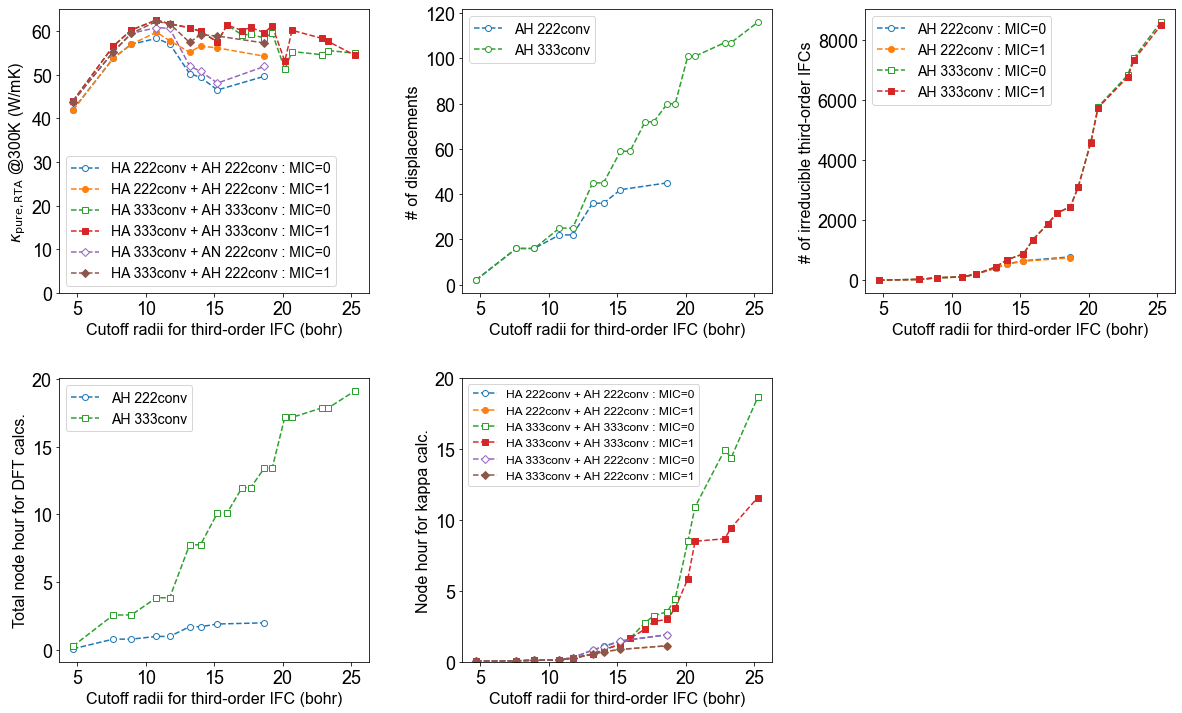

In [18]:
# 4. Anharmonic
# convergence w.r.t. cutoff radius
                             
# Plot data

fig = plt.figure(figsize=(20,12))
nrows = 2
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.3, wspace=0.3)

kappa_mic0 = kappa_all[kappa_all['Mirror image convention'] == 0]
kappa_mic1 = kappa_all[kappa_all['Mirror image convention'] == 1]


kappa_h2a2_mic0 = kappa_mic0[(kappa_mic0['SC size IFC2'] == '222conv_fine') & (kappa_mic0['SC size IFC3'] == '222conv_fine')]
kappa_h3a2_mic0 = kappa_mic0[(kappa_mic0['SC size IFC2'] == '333conv') & (kappa_mic0['SC size IFC3'] == '222conv_fine')]
kappa_h3a3_mic0 = kappa_mic0[(kappa_mic0['SC size IFC2'] == '333conv') & (kappa_mic0['SC size IFC3'] == '333conv')]
kappa_h2a2_mic1 = kappa_mic1[(kappa_mic1['SC size IFC2'] == '222conv_fine') & (kappa_mic1['SC size IFC3'] == '222conv_fine')]
kappa_h3a2_mic1 = kappa_mic1[(kappa_mic1['SC size IFC2'] == '333conv') & (kappa_mic1['SC size IFC3'] == '222conv_fine')]
kappa_h3a3_mic1 = kappa_mic1[(kappa_mic1['SC size IFC2'] == '333conv') & (kappa_mic1['SC size IFC3'] == '333conv')]


ax = plt.subplot(gs[0,0])
ax.plot(kappa_h2a2_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h2a2_mic0['kappa_{RTA,pure} (W/mK)'], marker='o', mfc='white', linestyle='--', label='HA 222conv + AH 222conv : MIC=0')
ax.plot(kappa_h2a2_mic1['Cutoff radius for IFC3 (bohr)'], kappa_h2a2_mic1['kappa_{RTA,pure} (W/mK)'], marker='o', linestyle='--', label='HA 222conv + AH 222conv : MIC=1')
ax.plot(kappa_h3a3_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h3a3_mic0['kappa_{RTA,pure} (W/mK)'], marker='s', mfc='white', linestyle='--', label='HA 333conv + AH 333conv : MIC=0')
ax.plot(kappa_h3a3_mic1['Cutoff radius for IFC3 (bohr)'], kappa_h3a3_mic1['kappa_{RTA,pure} (W/mK)'], marker='s', linestyle='--', label='HA 333conv + AH 333conv : MIC=1')
ax.plot(kappa_h3a2_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h3a2_mic0['kappa_{RTA,pure} (W/mK)'], marker='D', mfc='white', linestyle='--', label='HA 333conv + AN 222conv : MIC=0')
ax.plot(kappa_h3a2_mic1['Cutoff radius for IFC3 (bohr)'], kappa_h3a2_mic1['kappa_{RTA,pure} (W/mK)'], marker='D', linestyle='--', label='HA 333conv + AH 222conv : MIC=1')
ax.set_xlabel("Cutoff radii for third-order IFC (bohr)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_ylim(0,65)
ax.legend(loc='best', fontsize=14)

ax = plt.subplot(gs[0,1])
ax.plot(kappa_h2a2_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h2a2_mic0['# disp. patterns.'], marker='o', mfc='white', linestyle='--', label='AH 222conv')
ax.plot(kappa_h3a3_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h3a3_mic0['# disp. patterns.'], marker='o', mfc='white', linestyle='--', label='AH 333conv', color='C2')
ax.set_xlabel("Cutoff radii for third-order IFC (bohr)", fontsize=16)
ax.set_ylabel("# of displacements", fontsize=16)
ax.legend(loc='best', fontsize=14)

ax = plt.subplot(gs[0,2])
ax.plot(kappa_h2a2_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h2a2_mic0['# irred. IFC3'], marker='o', mfc='white', linestyle='--', label='AH 222conv : MIC=0')
ax.plot(kappa_h2a2_mic1['Cutoff radius for IFC3 (bohr)'], kappa_h2a2_mic1['# irred. IFC3'], marker='o', linestyle='--', label='AH 222conv : MIC=1')
ax.plot(kappa_h3a3_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h3a3_mic0['# irred. IFC3'], marker='s', mfc='white', linestyle='--', label='AH 333conv : MIC=0')
ax.plot(kappa_h3a3_mic1['Cutoff radius for IFC3 (bohr)'], kappa_h3a3_mic1['# irred. IFC3'], marker='s', linestyle='--', label='AH 333conv : MIC=1')
ax.set_xlabel("Cutoff radii for third-order IFC (bohr)", fontsize=16)
ax.set_ylabel("# of irreducible third-order IFCs", fontsize=16)
ax.legend(loc='best', fontsize=14)


ax = plt.subplot(gs[1,0])
#print(int(time_222conv_1[:,0]-1))
ax.plot(kappa_h2a2_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h2a2_mic0['node hour (vasp)'], marker='o', mfc='white', linestyle='--', label='AH 222conv')
ax.plot(kappa_h3a3_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h3a3_mic0['node hour (vasp)'], marker='s', mfc='white', linestyle='--', color='C2', label='AH 333conv')
ax.set_xlabel("Cutoff radii for third-order IFC (bohr)", fontsize=16)
ax.set_ylabel("Total node hour for DFT calcs.", fontsize=16)
ax.legend(loc='best', fontsize=14)


ax = plt.subplot(gs[1,1])
ax.plot(kappa_h2a2_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h2a2_mic0['node hour (kappa)'],marker='o', mfc='white', linestyle='--', label='HA 222conv + AH 222conv : MIC=0')
ax.plot(kappa_h2a2_mic1['Cutoff radius for IFC3 (bohr)'], kappa_h2a2_mic1['node hour (kappa)'], marker='o', linestyle='--', label='HA 222conv + AH 222conv : MIC=1')
ax.plot(kappa_h3a3_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h3a3_mic0['node hour (kappa)'], marker='s', mfc='white', linestyle='--', label='HA 333conv + AH 333conv : MIC=0')
ax.plot(kappa_h3a3_mic1['Cutoff radius for IFC3 (bohr)'], kappa_h3a3_mic1['node hour (kappa)'], marker='s', linestyle='--', label='HA 333conv + AH 333conv : MIC=1')
ax.plot(kappa_h3a2_mic0['Cutoff radius for IFC3 (bohr)'], kappa_h3a2_mic0['node hour (kappa)'], marker='D', mfc='white', linestyle='--', label='HA 333conv + AH 222conv : MIC=0')
ax.plot(kappa_h3a2_mic1['Cutoff radius for IFC3 (bohr)'], kappa_h3a2_mic1['node hour (kappa)'], marker='D', linestyle='--', label='HA 333conv + AH 222conv : MIC=1')

ax.set_xlabel("Cutoff radii for third-order IFC (bohr)", fontsize=16)
ax.set_ylabel("Node hour for kappa calc.", fontsize=16)
ax.set_ylim(0, 20)
ax.legend(loc='best', fontsize=12)

plt.savefig('kappa_convergence_cutoff_and_supercellsize.pdf', bbox_inches='tight')
plt.show()

In [19]:
temperature = 300
kappa_list = []
qlist = np.arange(10, 110, 10)

kappa_conv_kmesh = pd.DataFrame()

for q in qlist:
    fname = 'VASP/4.Anharmonic/222conv/3nn/cubic_q%d.kl' % q
    kappa_list.append(get_kappa_from_file(fname, temperature))

run_time = np.loadtxt('VASP/4.Anharmonic/222conv/3nn/elapsed_time.dat')

kappa_conv_kmesh['# q points along each axis'] = qlist
kappa_conv_kmesh['kappa_{RTA,pure} (W/mK)'] = kappa_list
kappa_conv_kmesh['node hour (kappa)'] = run_time[:,2]*run_time[:,1]/float(48 * 3600)

## 4.2 Anharmonic - convergence w.r.t. q mesh

The convergence of $\kappa_{L}$ with respect to the q point density was examined using the following computational conditions:

- `222conv_fine` supercell for second- and third-order IFCs
- Mass : 72.63 u **(Sorry, this is the standard atomic weight. I should have used 69.924 u instead, but the results are still valid because the purpose here is just to check the convergence.)**
- $r_c = 9.0$ bohr for third-order IFCs
- Increase q mesh from 10^3 to 100^3

The results below shows that $\kappa_{L}$ keeps increasing with increasing $N_q$.<br>
The computational cost increases dramatically (approximately proportional to $N_q^6$), but the improvement in the $\kappa_{L}$ value is very small in $N_q >50$.<br>
So, **we will use $N_q$ = 50 in the production run**.

In [20]:
kappa_conv_kmesh

,# q points along each axis,"kappa_{RTA,pure} (W/mK)",node hour (kappa)
0,10,48.0115,0.002222
1,20,53.9465,0.015556
2,30,55.8224,0.104444
3,40,57.1469,0.500000
4,50,57.6150,1.700000
5,60,57.9273,4.751111
6,70,58.0341,11.406667
7,80,58.2699,24.135556
8,90,58.4567,47.275556
9,100,58.5975,85.433333


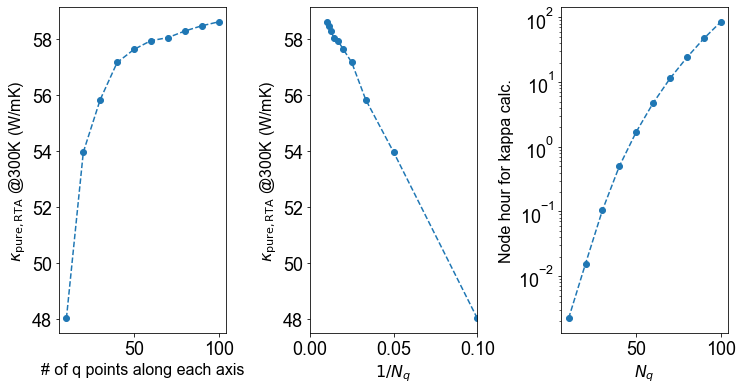

In [21]:
fig = plt.figure(figsize=(12,6))
nrows = 1
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.5)

ax = plt.subplot(gs[0])
qmesh = np.arange(10, 110, 10)

ax.plot(kappa_conv_kmesh['# q points along each axis'], 
        kappa_conv_kmesh['kappa_{RTA,pure} (W/mK)'], 
        marker='o', linestyle='--', label='3nn')
ax.set_xlabel('# of q points along each axis', fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)

ax = plt.subplot(gs[1])
qmesh = np.arange(10, 110, 10)

ax.plot(1.0/kappa_conv_kmesh['# q points along each axis'], 
        kappa_conv_kmesh['kappa_{RTA,pure} (W/mK)'], marker='o', linestyle='--', label='3nn')
ax.set_xlabel('$1/N_q$', fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_xlim(0,0.1)

ax = plt.subplot(gs[2])
ax.plot(kappa_conv_kmesh['# q points along each axis'], 
        kappa_conv_kmesh['node hour (kappa)'], marker='o', linestyle='--', label='3nn')
ax.set_xlabel('$N_q$', fontsize=16)
ax.set_ylabel("Node hour for kappa calc.", fontsize=16)
ax.set_yscale('log')
#ax.set_xlim(0,0.1)


## 4. Anharmonic - production run

After checking the convergence of kappa w.r.t. various parameters, I have chosen the following set of parameters for the production calculation.

- Lattice constant (Ang.) : 5.7019 
- ENCUT = 300
- SC for IFC2: `333conv`
- SC for IFC3: `222conv_fine`
- Cutoff radius for IFC3 (bohr): 9.0 (includes up to 3nn shells)
- 50x50x50 q points
- tetrahedron method for delta function
- Mass of Ge: 72.63 u for $\kappa_{nat}$, 69.924 u for $\kappa_{pure}$.
- isotope factor: 5.86712e-04 for $\kappa_{nat}$, 0 for $\kappa_{pure}$ 
- temperature step: 1 K (1,000 temperature points)

The results of the production calculation are shown in the following tables/figures.

In [31]:
#load data of production run

kl_pure = np.loadtxt('VASP/4.Anharmonic/222conv/3nn/pure_cubic_3nn_k50.kl', usecols=[0, 1])
kl_nat_iso = np.loadtxt('VASP/4.Anharmonic/222conv/3nn/kappa_iso_cubic_3nn_k50.kl', usecols=[0, 1])

target_temperatures = np.concatenate((np.arange(10, 50, 10), 
                                      np.arange(50, 300, 25),
                                      np.arange(300, 1001, 100)))

kl_pure_save = []
kl_nat_iso_save = []
for i in range(len(kl_pure)):
    if kl_pure[i,0] in target_temperatures:
        kl_pure_save.append(kl_pure[i,1])

for i in range(len(kl_nat_iso)):
    if kl_nat_iso[i,0] in target_temperatures:
        kl_nat_iso_save.append(kl_nat_iso[i,1])
        
kl_production = pd.DataFrame()
kl_production['temperature (K)'] = target_temperatures
kl_production['kappa_{nat, RTA} (W/mK)'] = kl_nat_iso_save
kl_production['kappa_{pure, RTA} (W/mK)'] = kl_pure_save

kl_pure_accum = pd.read_table('VASP/4.Anharmonic/222conv/3nn/pure_cubic_3nn_k50_cumulative.dat', comment='#', 
                              header=None, names=['mfp (nm)', 'cumulative kappa (W/mK)'], 
                              delim_whitespace=True, usecols=[0, 1])

kl_nat_accum = pd.read_table('VASP/4.Anharmonic/222conv/3nn/nat_iso_cubic_3nn_k50_cumulative.dat', comment='#', 
                             header=None, names=['mfp (nm)', 'cumulative kappa (W/mK)'], 
                             delim_whitespace=True, usecols=[0, 1])
kl_pure_spec = pd.read_table('VASP/4.Anharmonic/222conv/3nn/pure_cubic_3nn_k50.kl_spec', comment='#',
                             header=None, names=['temperature (K)', 'omega (cm^-1)', 'kappa spec'],
                             delim_whitespace=True, usecols=[0, 1, 2])
kl_nat_spec = pd.read_table('VASP/4.Anharmonic/222conv/3nn/kappa_iso_cubic_3nn_k50.kl_spec', comment='#',
                             header=None, names=['temperature (K)', 'omega (cm^-1)', 'kappa spec'],
                             delim_whitespace=True, usecols=[0, 1, 2])
kl_pure_spec = kl_pure_spec[kl_pure_spec['temperature (K)'] == 300]
kl_nat_spec = kl_nat_spec[kl_nat_spec['temperature (K)'] == 300]

#convert unit of kl_spec

kl_pure_spec['omega (cm^-1)'] *= kayser_to_THz
kl_pure_spec['kappa spec'] /= kayser_to_THz
kl_pure_spec.rename(columns={'omega (cm^-1)': 'frequency (THz)', 'kappa spec' : 'kappa spec (W/mK/THz)'}, inplace=True)

kl_nat_spec['omega (cm^-1)'] *= kayser_to_THz
kl_nat_spec['kappa spec'] /= kayser_to_THz
kl_nat_spec.rename(columns={'omega (cm^-1)': 'frequency (THz)', 'kappa spec' : 'kappa spec (W/mK/THz)'}, inplace=True)

kl_production

,temperature (K),"kappa_{nat, RTA} (W/mK)","kappa_{pure, RTA} (W/mK)"
0,10,4164.6404,81248.4561
1,20,1533.4823,14143.2884
2,30,925.5216,5728.8972
3,40,678.0002,2704.8869
4,50,517.7304,1439.3737
5,75,286.6413,508.9327
6,100,187.9214,281.0113
7,125,139.4809,191.3812
8,150,111.5504,145.3769
9,175,93.4468,117.6502


In [23]:
mode_contribution_nat = pd.read_table('VASP/4.Anharmonic/222conv/3nn/tau_300K_q50_nat.dat', comment='#',
                                      header=None, 
                                      names=['iq (irred.)', 'ib', 'f (cm^-1)', 'lifetime (ps)', 'mfp (nm)', 
                                             'multiplicity', 'modal kappa (W/mK)'],
                                      delim_whitespace=True, usecols=[0, 1, 2, 3, 5, 6, 7])

mode_contribution_nat_iso = pd.read_table('VASP/4.Anharmonic/222conv/3nn/tau_300K_q50_nat_iso.dat', comment='#',
                                          header=None, 
                                          names=['iq (irred.)', 'ib', 'f (cm^-1)', 'lifetime (ps)', 'mfp (nm)', 
                                                 'multiplicity', 'modal kappa (W/mK)'],
                                          delim_whitespace=True, usecols=[0, 1, 2, 3, 5, 6, 7])

mode_contribution_nat['f (cm^-1)'] *= kayser_to_THz
mode_contribution_nat_iso['f (cm^-1)'] *= kayser_to_THz

mode_contribution_nat.rename(columns={'f (cm^-1)' : 'f (THz)'}, inplace=True)
mode_contribution_nat_iso.rename(columns={'f (cm^-1)' : 'f (THz)'}, inplace=True)

scattering_rates = mode_contribution_nat.iloc[:,0:3]
scattering_rates['1/tau_3ph (THz)'] = 1.0 / mode_contribution_nat['lifetime (ps)']
scattering_rates['1/tau_iso (THz)'] = 1.0 / mode_contribution_nat_iso['lifetime (ps)'] - 1.0 / mode_contribution_nat['lifetime (ps)']
scattering_rates.at[0, '1/tau_3ph (THz)'] = 0
scattering_rates.at[1, '1/tau_3ph (THz)'] = 0
scattering_rates.at[2, '1/tau_3ph (THz)'] = 0
scattering_rates.at[0, '1/tau_iso (THz)'] = 0
scattering_rates.at[1, '1/tau_iso (THz)'] = 0
scattering_rates.at[2, '1/tau_iso (THz)'] = 0

In [24]:
mode_contribution_nat_iso

,iq (irred.),ib,f (THz),lifetime (ps),mfp (nm),multiplicity,modal kappa (W/mK)
0,1,1,3.289832e-12,0.00000,0.000000,1,0.000000e+00
1,1,2,3.289832e-12,0.00000,0.000000,1,0.000000e+00
2,1,3,3.289832e-12,0.00000,0.000000,1,0.000000e+00
3,1,4,8.469826e+00,1.93132,0.000000,1,0.000000e+00
4,1,5,8.469826e+00,1.93132,0.000000,1,0.000000e+00
...,...,...,...,...,...,...,...
18637,3107,2,3.043553e+00,12.18500,2.549820,12,4.156040e-07
18638,3107,3,5.883337e+00,1.57527,0.374041,12,6.557070e-08
18639,3107,4,5.883337e+00,1.57527,0.374202,12,6.562700e-08
18640,3107,5,7.926962e+00,1.79782,0.014979,12,8.686780e-11


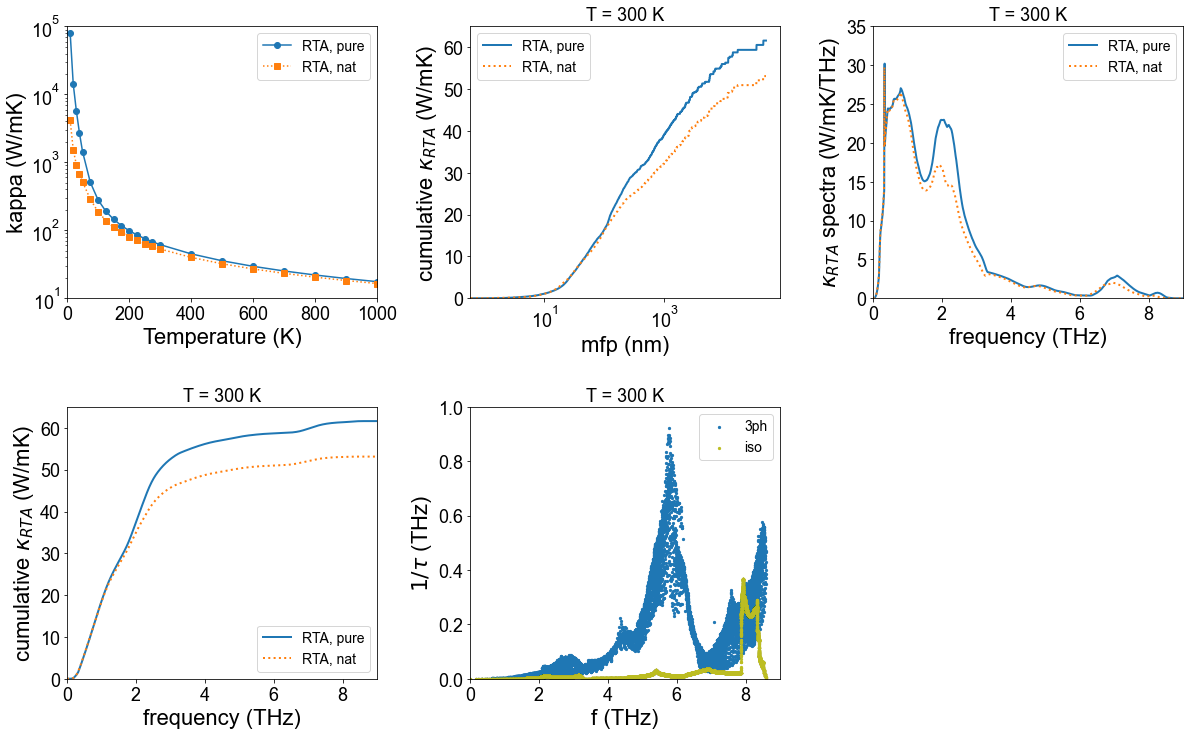

In [27]:
# Plot data

fig = plt.figure(figsize=(20,12))
nrows = 2
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.4, wspace=0.3)

ax = plt.subplot(gs[0])
ax.plot(kl_production['temperature (K)'], kl_production['kappa_{pure, RTA} (W/mK)'], linestyle='-', marker='o', label='RTA, pure')
ax.plot(kl_production['temperature (K)'], kl_production['kappa_{nat, RTA} (W/mK)'], linestyle=':', marker='s', label='RTA, nat')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('kappa (W/mK)')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim(0,1000)
ax.set_ylim(10,1e+5)
ax.legend(loc='best', fontsize=14)

ax = plt.subplot(gs[1])
kl_pure_accum.plot(x=0, y=1, ax=ax, ylabel=r'cumulative $\kappa_{RTA}$ (W/mK)', linewidth=2.0, label="RTA, pure")
kl_nat_accum.plot(x=0, y=1, ax=ax, ylabel=r'cumulative $\kappa_{RTA}$ (W/mK)', linewidth=2.0, linestyle=':', label="RTA, nat")
ax.set_ylim(0, 65)
ax.legend(loc='best', fontsize=14)
ax.set_xscale('log')
ax.set_title('T = 300 K', fontsize=18)


ax = plt.subplot(gs[2])
kl_pure_spec.plot(x=1, y=2, ax=ax, linewidth=2.0, label="RTA, pure")
kl_nat_spec.plot(x=1, y=2, ax=ax, ylabel=r'$\kappa_{RTA}$ spectra (W/mK/THz)', linewidth=2.0, linestyle=":", label="RTA, nat")
ax.set_xlim(0, 9)
ax.set_ylim(0, 35)
ax.legend(loc='best', fontsize=14)
ax.set_title('T = 300 K', fontsize=18)



ax = plt.subplot(gs[3])
ax.plot(kl_pure_spec['frequency (THz)'], kl_pure_spec['kappa spec (W/mK/THz)'].cumsum()*0.2*kayser_to_THz, linewidth=2.0, linestyle='-', label="RTA, pure")
ax.plot(kl_nat_spec['frequency (THz)'], kl_nat_spec['kappa spec (W/mK/THz)'].cumsum()*0.2*kayser_to_THz, linewidth=2.0, linestyle=':', label="RTA, nat")
#kl_pure_spec.plot(x=1, y=2, ax=ax, linewidth=2.0, label="RTA, pure")
#kl_nat_spec.plot(x=1, y=2, ax=ax, ylabel=r'$\kappa_{RTA}$ spectra (W/mK/THz)', linewidth=2.0, linestyle=":", label="RTA, nat")
ax.set_xlim(0, 9)
ax.set_ylim(0, 65)
ax.set_xlabel('frequency (THz)')
ax.set_ylabel(r'cumulative $\kappa_{RTA}$ (W/mK)')
ax.legend(loc='best', fontsize=14)
ax.set_title('T = 300 K', fontsize=18)


ax = plt.subplot(gs[4])
scattering_rates.plot(x=2, y=3, ax=ax, kind='scatter', marker='.', label='3ph')
scattering_rates.plot(x=2, y=4, ax=ax, kind='scatter', marker='.', label='iso', color='C8', ylabel=r'$1/\tau$ (THz)')
ax.legend(loc='best', fontsize=14)
ax.set_title('T = 300 K', fontsize=18)
ax.set_xlim(0, 9)
ax.set_ylim(0, 1.0)

plt.savefig('production_kappa.pdf', bbox_inches='tight')
plt.show()

In [32]:
# write all dataframes to excel

wb = openpyxl.Workbook()

ws = wb.create_sheet(title='struct. opt. (vasp)')
write_dataframe_to_excel(ws, vasp_ismear2_encut, irow=3, icol=3)
write_dataframe_to_excel(ws, vasp_ismear2_kmesh, irow=3, icol=15)


ws = wb.create_sheet(title='elec. bands (vasp)')
ws.cell(row=2, column=5, value='Band structure\n(SCF 8x8x8 MP k points)').font = font
ws.cell(row=3, column=5, value='Fermi energy (eV)').font = font
ws.cell(row=3, column=6, value=bs1[0].attrs['efermi']).font = font

irow_now = 5
icol_now = 5
    
for i in range(len(pathes)):
    ws.cell(row=irow_now, column=icol_now, value=bs1[i].attrs['line']).font = font
    write_dataframe_to_excel(ws, bs1[i], irow=irow_now + 1, icol=icol_now)
    nrow_add, _ = bs1[i].shape
    irow_now += (nrow_add + 3)

icol_now += len(bs1[0].columns) + 3
ws.cell(row=2, column=icol_now, value='Band structure\n(SCF 8x8x8 MP k points)').font = font
ws.cell(row=3, column=icol_now, value='Fermi energy (eV)').font = font
ws.cell(row=3, column=icol_now+1, value=bs2[0].attrs['efermi']).font = font
    
irow_now = 5
for i in range(len(pathes)):
    ws.cell(row=irow_now, column=icol_now, value=bs2[i].attrs['line']).font = font
    write_dataframe_to_excel(ws, bs2[i], irow=irow_now + 1, icol=icol_now)
    nrow_add, _ = bs2[i].shape
    irow_now += (nrow_add + 3)

    
ws = wb.create_sheet(title='ph bands (alamode)')

supercells_to_save = ['222conv_fine', '444conv_fine']

icol_now = 3
icount = 0

for i, sc in enumerate(supercells):
    
    if sc not in supercells_to_save:
        continue

    icount += 1
    if icount > 1:
        icol_now += 10

    irow_now = 3
    ws.cell(row=irow_now, column=icol_now, value='Phonon dispersion \n(%s)' % supercell_labels[i]).font = font
    irow_now += 2
    
    for j, path in enumerate(pathes):
        ws.cell(row=irow_now, column=icol_now, value=path).font = font
        write_dataframe_to_excel(ws, phband_data[i][j], irow=irow_now + 1, icol=icol_now)
        nrows, _ = phband_data[i][j].shape
        irow_now += (nrows + 4)
        
ws = wb.create_sheet(title='kappa conv. check1')

write_dataframe_to_excel(ws, kappa_all, irow=3, icol = 3)

ws = wb.create_sheet(title='kappa conv. check2')

ws.cell(row = 2, column=3, value="Convergence w.r.t. q mesh").font = font
ws.cell(row = 4, column=3, value="SC size for IFC2").font = font
ws.cell(row = 4, column=4, value="222conv_fine").font = font
ws.cell(row = 5, column=3, value="SC size for IFC3").font = font
ws.cell(row = 5, column=4, value="222conv_fine").font = font
ws.cell(row = 6, column=3, value="Mass of Ge").font = font
ws.cell(row = 6, column=4, value=72.63).font = font
ws.cell(row = 7, column=3, value="cutoff radii for IFC3 (bohr)").font = font
ws.cell(row = 7, column=4, value=8.94).font = font
        
write_dataframe_to_excel(ws, kappa_conv_kmesh, irow=4, icol=7)

ws = wb.create_sheet(title='production kappa')

ws.cell(row = 2, column=3, value="Production run of kappa calculation with converged settings").font = font
ws.cell(row = 4, column=3, value="SC size for IFC2").font = font
ws.cell(row = 4, column=4, value="333conv").font = font
ws.cell(row = 5, column=3, value="SC size for IFC3").font = font
ws.cell(row = 5, column=4, value="222conv_fine").font = font
ws.cell(row = 6, column=3, value="cutoff radii for IFC3 (bohr)").font = font
ws.cell(row = 6, column=4, value=8.94).font = font

ws.cell(row = 8, column=3, value="Mass of Ge").font = font
ws.cell(row = 8, column=4, value=69.924).font = font
ws.cell(row = 8, column=5, value="for 'pure' case").font = font
ws.cell(row = 9, column=4, value=72.63).font = font
ws.cell(row = 9, column=5, value="for 'nat' case").font = font
ws.cell(row = 10, column=3, value="isotope factor").font = font
ws.cell(row = 10, column=4, value=5.86712e-04).font = font
ws.cell(row = 11, column=3, value="qmesh").font = font
ws.cell(row = 11, column=4, value="50 50 50").font = font

write_dataframe_to_excel(ws, kl_production, irow=4, icol=7)

ws = wb.create_sheet(title='production k_acc@300K')
ws.cell(row = 2, column=3, value="Production run of cumulative kappa at 300 K").font = font
ws.cell(row = 3, column=3, value="cumulative value w.r.t. mean-free-path (mfp)").font = font
ws.cell(row = 4, column=3, value="ph-iso scattering included.").font = font
write_dataframe_to_excel(ws, kl_nat_accum, irow=2, icol=5)

ws = wb.create_sheet(title='production k_spec@300K')
ws.cell(row = 2, column=3, value="Production run of cumulative kappa at 300 K").font = font
ws.cell(row = 3, column=3, value="cumulative value w.r.t. frequency (THz)").font = font
ws.cell(row = 4, column=3, value="ph-iso scattering included.").font = font
data_tmp = pd.DataFrame()
data_tmp['frequency (THz)'] = kl_nat_spec['frequency (THz)']
data_tmp['kappa spec (W/mK/THz)'] = kl_nat_spec['kappa spec (W/mK/THz)']
data_tmp['cumulative sum (W/mK)'] = kl_nat_spec['kappa spec (W/mK/THz)'].cumsum()*0.2*kayser_to_THz
write_dataframe_to_excel(ws, data_tmp, irow=2, icol=5)


ws = wb.create_sheet(title='production scatt. rate@300K')
ws.cell(row = 2, column=3, value="Production data of scattering rates at 300 K").font = font
ws.cell(row = 3, column=3, value="Dirac delta function was evaluated by using tetrahedron method").font = font
ws.cell(row = 4, column=3, value="Mass of Ge").font = font
ws.cell(row = 4, column=4, value=72.63).font = font
ws.cell(row = 5, column=3, value="isotope factor").font = font
ws.cell(row = 5, column=4, value=5.86712e-04).font = font
ws.cell(row = 6, column=3, value="qmesh").font = font
ws.cell(row = 6, column=4, value="50 50 50").font = font

write_dataframe_to_excel(ws, scattering_rates, irow=2, icol=5)

ws = wb.create_sheet(title='production mode contrib.@300K')
ws.cell(row = 2, column=3, value="Production data of mode-decomposed kappa at 300 K").font = font

write_dataframe_to_excel(ws, mode_contribution_nat_iso, irow=2, icol=5)

wb.save('Ge_alamode_tadano.xlsx')